# Tutorial 03: Forecast Error Variance Decomposition (FEVD)

**Duration:** 60-90 minutes  
**Level:** Intermediate  
**Prerequisites:** Notebooks 01 (Panel VAR Introduction) and 02 (IRF Analysis)

## Learning Objectives

By the end of this notebook, you will be able to:

1. Understand how FEVD decomposes forecast error variance to quantify the **relative importance** of shocks
2. Compute and interpret **Cholesky FEVD** with explicit variable ordering
3. Calculate **order-invariant Generalized FEVD** (Pesaran-Shin)
4. Visualize variance decomposition with **stacked area charts**
5. Apply FEVD to **economic policy analysis** and **financial contagion** questions
6. Construct **bootstrap confidence intervals** for FEVD shares
7. Verify **FEVD-IRF consistency**: large IRF responses correspond to large FEVD shares

## Outline

1. [FEVD Theory](#1-fevd-theory)
2. [Computing FEVD](#2-computing-fevd)
3. [Stacked Area Visualization](#3-stacked-area-visualization)
4. [Generalized FEVD](#4-generalized-fevd)
5. [Economic Applications](#5-economic-applications)
6. [Bootstrap Confidence Intervals](#6-bootstrap-confidence-intervals)
7. [FEVD-IRF Consistency](#7-fevd-irf-consistency)
8. [Exercises](#8-exercises)

---

In [1]:
# Setup
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Add project root to path
project_root = Path("../../..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# PanelBox imports
from panelbox.var import PanelVAR, PanelVARData

# Tutorial utilities
sys.path.insert(0, str(Path("..").resolve()))
from utils.visualization_helpers import plot_fevd_stacked, set_academic_style

# Plot style
set_academic_style()
warnings.filterwarnings('ignore', category=UserWarning)
%matplotlib inline

# Reproducibility
np.random.seed(42)

# Output directories
FIGURE_DIR = Path('../outputs/figures/fevds')
TABLE_DIR = Path('../outputs/tables')
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)

print("Setup complete.")

Setup complete.


## 1. FEVD Theory

### The Fundamental Question

While **Impulse Response Functions (IRFs)** tell us *how* variable $Y_i$ responds to a shock in $Y_j$, they do not tell us *how important* that shock is relative to other shocks. This is the central question that **Forecast Error Variance Decomposition (FEVD)** answers:

> **"Of the total variance of $Y_i$ at forecast horizon $h$, what percentage comes from shocks to $Y_j$?"**

FEVD partitions the forecast error variance of each variable into contributions from each structural shock, providing a natural measure of **relative importance**.

### The FEVD Formula (Cholesky)

For a VAR model with orthogonalized (Cholesky) IRFs $\Phi_s$, the share of forecast error variance of variable $i$ at horizon $h$ attributable to shock $j$ is:

$$\omega_{ij}(h) = \frac{\sum_{s=0}^{h} \Phi_s[i,j]^2}{\sum_{s=0}^{h} \sum_{k=1}^{K} \Phi_s[i,k]^2}$$

where:
- **Numerator**: cumulative squared IRF of variable $i$ to shock $j$ through horizon $h$
- **Denominator**: total forecast error variance of variable $i$ through horizon $h$ (summed across all $K$ shocks)

### Key Properties

1. **Shares sum to 1**: $\sum_{j=1}^{K} \omega_{ij}(h) = 1$ for each variable $i$ and horizon $h$
2. **Bounded**: $\omega_{ij}(h) \in [0, 1]$
3. **Horizon-dependent**: the relative importance of shocks evolves over time
4. **At $h=0$**: under Cholesky, own shocks explain 100% for the first variable in the ordering

### Complementarity with IRF

| Aspect | IRF | FEVD |
|--------|-----|------|
| Question | How does $Y_i$ respond to shock $j$? | How much of $Y_i$'s variance comes from shock $j$? |
| Units | Same as $Y_i$ | Percentage (0-100%) |
| Sign information | Yes (direction of response) | No (only magnitude/importance) |
| Visualization | Line plots with CIs | Stacked area charts |
| Use case | Trace dynamic propagation | Rank shock importance |

### Load Data and Estimate VAR

We continue with the macroeconomic panel from Notebooks 01-02.

In [2]:
# Load macroeconomic panel data
df_macro = pd.read_csv('../data/macro_panel.csv')
df_macro['quarter'] = pd.PeriodIndex(df_macro['quarter'], freq='Q')

print(f"Dataset shape: {df_macro.shape}")
print(f"Countries: {df_macro['country'].nunique()}")
print(f"Quarters: {df_macro['quarter'].nunique()}")
print(f"\nVariables: {list(df_macro.columns)}")
print(f"\nSample:")
df_macro.head()

Dataset shape: (1200, 7)
Countries: 30
Quarters: 40

Variables: ['country', 'quarter', 'gdp_growth', 'inflation', 'interest_rate', 'unemployment', 'exchange_rate']

Sample:


,country,quarter,gdp_growth,inflation,interest_rate,unemployment,exchange_rate
0,USA,2010Q1,0.692341,4.189052,5.030471,12.376956,98.170049
1,USA,2010Q2,0.387922,3.090266,1.703063,10.128024,97.349193
2,USA,2010Q3,0.451509,4.755641,1.420913,10.607511,97.377636
3,USA,2010Q4,3.727293,2.010963,4.140729,9.955421,95.618850
4,USA,2011Q1,3.520028,3.021079,3.300164,9.393912,96.046546


In [3]:
# Define the 3-variable system: monetary policy -> inflation -> output
endog_vars = ['interest_rate', 'inflation', 'gdp_growth']

# Create PanelVARData
var_data = PanelVARData(
    df_macro,
    endog_vars=endog_vars,
    entity_col='country',
    time_col='quarter',
    lags=2
)

# Estimate the VAR
model = PanelVAR(var_data)
results = model.fit(method='ols', cov_type='clustered')

print("VAR(2) estimated successfully.")
print(f"Variables: {endog_vars}")
print(f"Lags: 2")

VAR(2) estimated successfully.
Variables: ['interest_rate', 'inflation', 'gdp_growth']
Lags: 2


---

## 2. Computing FEVD

We compute the **Cholesky FEVD** using the recursive ordering: `interest_rate -> inflation -> gdp_growth`. This ordering assumes that monetary policy affects inflation and output contemporaneously, but output shocks do not affect interest rates within the same quarter.

In [4]:
# Compute Cholesky FEVD
fevd = results.fevd(
    periods=20,
    method='cholesky',
    order=['interest_rate', 'inflation', 'gdp_growth'],
)

print(f"FEVD object: {fevd}")
print(f"Decomposition shape: {fevd.decomposition.shape}  (periods+1, K, K)")
print(f"Variables: {fevd.var_names}")
print(f"Method: {fevd.method}")
print(f"K = {fevd.K}, periods = {fevd.periods}")

FEVD object: FEVDResult(K=3, periods=20, method='cholesky')
Decomposition shape: (21, 3, 3)  (periods+1, K, K)
Variables: ['interest_rate', 'inflation', 'gdp_growth']
Method: cholesky
K = 3, periods = 20


In [5]:
# Display summary at selected horizons
print(fevd.summary(horizons=[1, 5, 10, 20]))

Forecast Error Variance Decomposition (CHOLESKY)
Method: cholesky
Ordering: interest_rate, inflation, gdp_growth

Variable: interest_rate
--------------------------------------------------------------------------------
     Horizon  Shock interest_rate  Shock inflation  Shock gdp_growth
--------------------------------------------------------------------------------
         h=1        95.47%         4.51%         0.02%
         h=5        79.85%        16.02%         4.14%
        h=10        79.00%        16.51%         4.49%
        h=20        78.99%        16.52%         4.49%

Variable: inflation
--------------------------------------------------------------------------------
     Horizon  Shock interest_rate  Shock inflation  Shock gdp_growth
--------------------------------------------------------------------------------
         h=1         0.09%        99.53%         0.38%
         h=5         1.10%        97.38%         1.52%
        h=10         1.31%        97.16%         

### Extracting and Interpreting FEVD for GDP Growth

The `decomposition` array has shape `(periods+1, K, K)`, where:
- `decomposition[h, i, j]` = share of variance of variable `i` explained by shock `j` at horizon `h`

Let's extract the decomposition for GDP growth and examine how each shock's contribution evolves over the forecast horizon.

In [6]:
# Extract FEVD for GDP growth using direct array indexing
gdp_idx = fevd.var_names.index('gdp_growth')
fevd_gdp = fevd.decomposition[:, gdp_idx, :]  # shape: (periods+1, K)

print(f"FEVD for GDP growth - shape: {fevd_gdp.shape}")
print(f"\nShock contributions at each horizon:")
print(f"{'Horizon':>8} | ", end="")
for var in fevd.var_names:
    print(f"{var:>16}", end=" | ")
print(f"{'Sum':>8}")
print("-" * 75)

for h in [0, 1, 2, 5, 10, 15, 20]:
    print(f"{h:>8} | ", end="")
    for j in range(fevd.K):
        print(f"{fevd_gdp[h, j]:>15.4f}", end=" | ")
    print(f"{fevd_gdp[h, :].sum():>8.4f}")

FEVD for GDP growth - shape: (21, 3)

Shock contributions at each horizon:
 Horizon |    interest_rate |        inflation |       gdp_growth |      Sum
---------------------------------------------------------------------------
       0 |          0.0019 |          0.0231 |          0.9749 |   1.0000
       1 |          0.0164 |          0.0233 |          0.9603 |   1.0000
       2 |          0.0451 |          0.0235 |          0.9313 |   1.0000
       5 |          0.0820 |          0.0277 |          0.8903 |   1.0000
      10 |          0.0835 |          0.0331 |          0.8834 |   1.0000
      15 |          0.0836 |          0.0332 |          0.8833 |   1.0000
      20 |          0.0836 |          0.0332 |          0.8832 |   1.0000


In [7]:
# Create a formatted DataFrame showing decomposition at key horizons
key_horizons = [1, 5, 10, 20]

# Use the to_dataframe method
df_fevd_gdp = fevd.to_dataframe(variable='gdp_growth')

# Filter to key horizons
df_fevd_table = df_fevd_gdp[df_fevd_gdp['horizon'].isin(key_horizons)].copy()

# Convert to percentages for display
for var in fevd.var_names:
    df_fevd_table[var] = df_fevd_table[var].apply(lambda x: f"{x * 100:.2f}%")

df_fevd_table = df_fevd_table.set_index('horizon')
df_fevd_table.index.name = 'Horizon'

print("FEVD of GDP Growth at Key Horizons")
print("=" * 60)
print(df_fevd_table.to_string())

# Save to CSV
df_fevd_raw = fevd.to_dataframe(variable='gdp_growth')
df_fevd_raw = df_fevd_raw[df_fevd_raw['horizon'].isin(key_horizons)]
df_fevd_raw.to_csv(TABLE_DIR / '03_fevd_gdp_growth.csv', index=False)
print(f"\nTable saved to {TABLE_DIR / '03_fevd_gdp_growth.csv'}")

FEVD of GDP Growth at Key Horizons
        interest_rate inflation gdp_growth
Horizon                                   
1               1.64%     2.33%     96.03%
5               8.20%     2.77%     89.03%
10              8.35%     3.31%     88.34%
20              8.36%     3.32%     88.32%

Table saved to ../outputs/tables/03_fevd_gdp_growth.csv


### Interpreting the FEVD Table

Read the table as follows:

- **At horizon 1** (one-step-ahead): The decomposition reflects mostly the contemporaneous structure. Under Cholesky ordering, `gdp_growth` (last in the ordering) can be affected contemporaneously by all variables.
- **At longer horizons** (h=10, 20): The decomposition stabilizes. The shares converge to their long-run values, showing the persistent sources of GDP uncertainty.

Key questions to answer:
1. How much of GDP forecast variance is due to **own shocks** vs. **external shocks**?
2. Is **monetary policy** (interest rate shocks) an important driver of GDP uncertainty?
3. Do **inflation shocks** transmit uncertainty to output?

---

## 3. Stacked Area Visualization

Stacked area charts are the standard visualization for FEVD. They show how the composition of forecast error variance evolves over the forecast horizon, with each color band representing the contribution of a different shock.

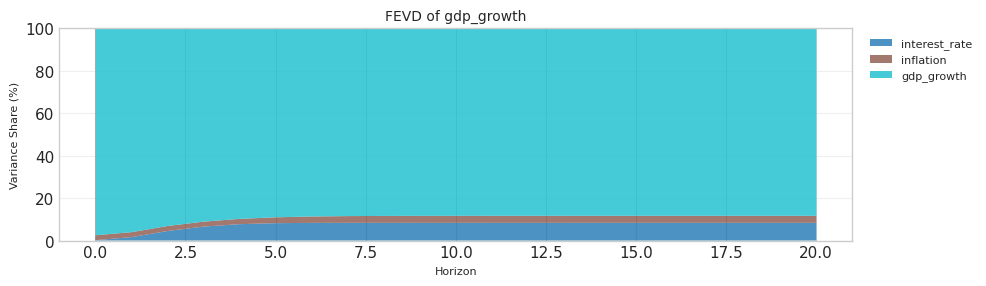

In [8]:
# Built-in plot for GDP growth
fig = fevd.plot(
    variables=['gdp_growth'],
    backend='matplotlib',
    show=False
)
plt.tight_layout()
plt.savefig(FIGURE_DIR / '03_fevd_gdp_builtin.png', dpi=150, bbox_inches='tight')
plt.show()

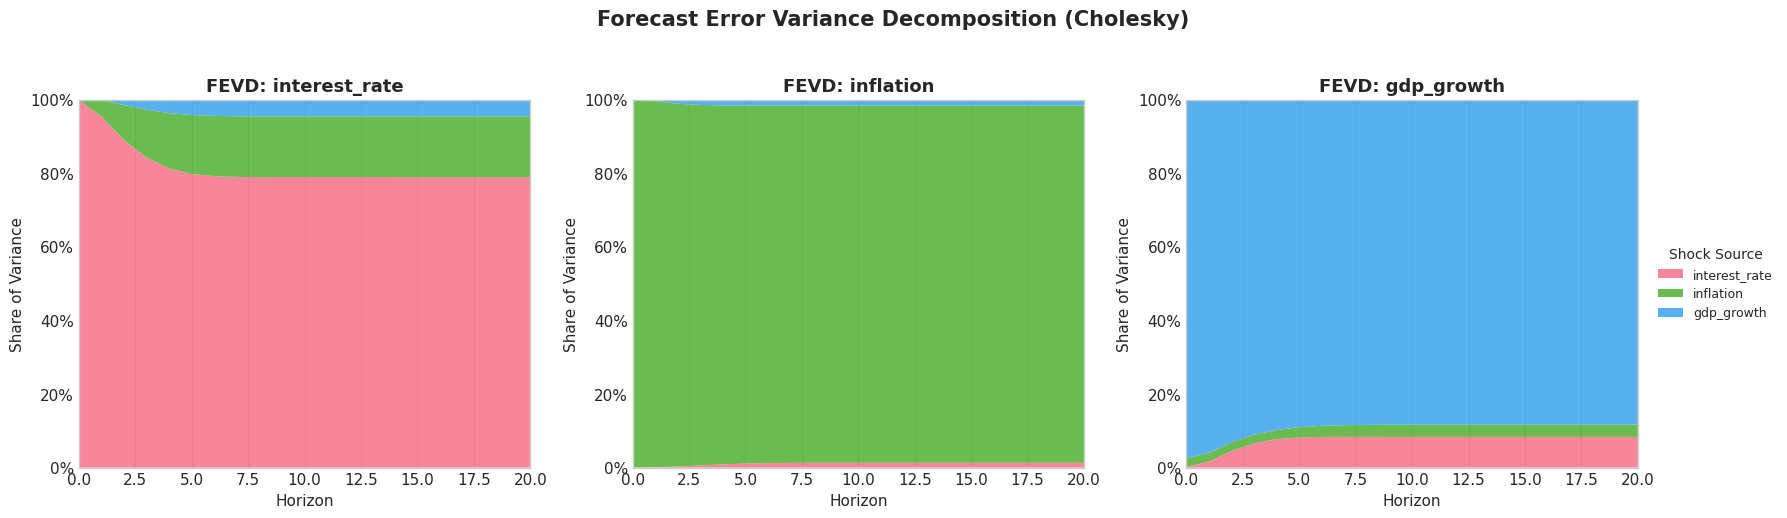

In [9]:
# Manual stacked area plot with full customization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = sns.color_palette('husl', n_colors=fevd.K)
horizons = np.arange(fevd.periods + 1)

for ax_idx, var in enumerate(fevd.var_names):
    ax = axes[ax_idx]
    var_idx = fevd.var_names.index(var)
    decomp = fevd.decomposition[:, var_idx, :]  # (periods+1, K)

    # Create stacked area plot
    ax.stackplot(
        horizons,
        *[decomp[:, j] for j in range(fevd.K)],
        labels=fevd.var_names,
        colors=colors,
        alpha=0.85
    )

    ax.set_xlabel('Horizon', fontsize=11)
    ax.set_ylabel('Share of Variance', fontsize=11)
    ax.set_title(f'FEVD: {var}', fontsize=13, fontweight='bold')
    ax.set_xlim(0, fevd.periods)
    ax.set_ylim(0, 1.0)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.grid(True, alpha=0.3, axis='y')

    if ax_idx == 2:
        ax.legend(
            loc='center left', bbox_to_anchor=(1.02, 0.5),
            title='Shock Source', fontsize=9, title_fontsize=10
        )

fig.suptitle(
    'Forecast Error Variance Decomposition (Cholesky)',
    fontsize=15, fontweight='bold', y=1.03
)
fig.tight_layout()
fig.savefig(FIGURE_DIR / '03_fevd_all_variables.png', dpi=150, bbox_inches='tight')
plt.show()

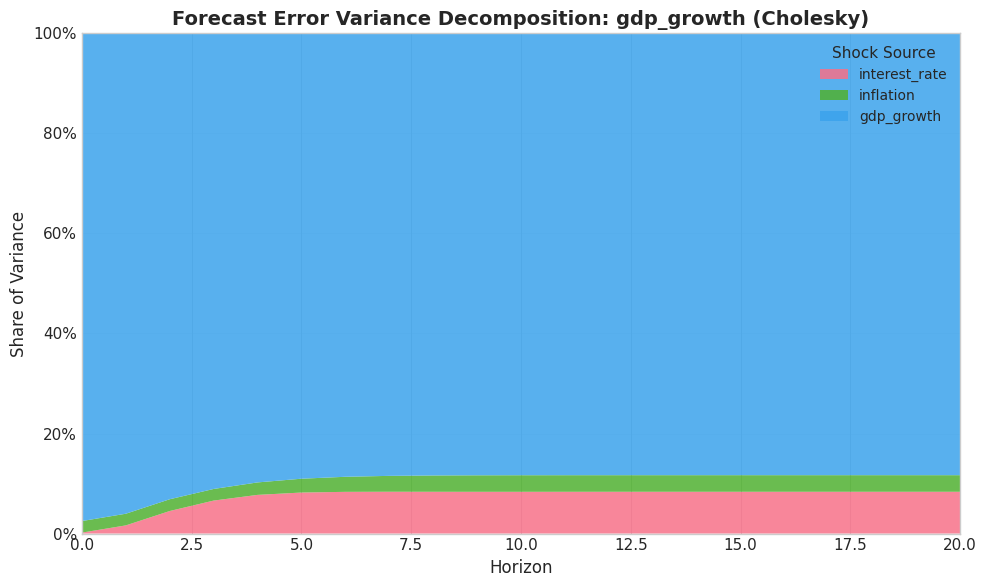

In [10]:
# Use the utility function for a single variable
fig = plot_fevd_stacked(
    fevd,
    variable='gdp_growth',
    save_path=str(FIGURE_DIR / '03_fevd_gdp_stacked.png')
)
plt.show()

### Interpreting Stacked Area Charts

Reading the chart:

- **Width of each band at horizon $h$** = the share of forecast error variance explained by that shock
- **Total area always sums to 100%** (1.0 on the y-axis) at every horizon
- **Evolution over time**: watch how bands widen or narrow as the horizon increases

Common patterns:
- **Own-shock dominance**: if a variable's own shock band stays wide, it is largely self-determined
- **External transmission**: if other shocks' bands grow at longer horizons, they transmit uncertainty with a lag
- **Convergence**: shares typically stabilize at longer horizons (h > 10-15)

---

## 4. Generalized FEVD

### The Ordering Problem

Cholesky FEVD depends on the **ordering** of variables. The first variable in the ordering cannot be contemporaneously affected by others, which imposes strong assumptions.

### Generalized FEVD (Pesaran and Shin, 1998)

**Generalized FEVD** is **order-invariant**. It uses the observed covariance structure of errors rather than orthogonalizing them. Key features:

- Does not require specifying a recursive ordering
- Uses the actual error covariance matrix directly
- The rows may not sum exactly to 1 before normalization (they are normalized in practice)
- Provides a more robust decomposition when economic theory does not clearly dictate ordering

In [11]:
# Compute Generalized FEVD (order-invariant)
fevd_gen = results.fevd(
    periods=20,
    method='generalized'
)

print(f"Generalized FEVD: {fevd_gen}")
print(f"Method: {fevd_gen.method}")
print()
print(fevd_gen.summary(horizons=[1, 5, 10, 20]))

Generalized FEVD: FEVDResult(K=3, periods=20, method='generalized')
Method: generalized

Forecast Error Variance Decomposition (GENERALIZED)
Method: generalized

Variable: interest_rate
--------------------------------------------------------------------------------
     Horizon  Shock interest_rate  Shock inflation  Shock gdp_growth
--------------------------------------------------------------------------------
         h=1        94.49%         4.92%         0.60%
         h=5        76.67%        16.10%         7.23%
        h=10        75.79%        16.54%         7.66%
        h=20        75.78%        16.55%         7.67%

Variable: inflation
--------------------------------------------------------------------------------
     Horizon  Shock interest_rate  Shock inflation  Shock gdp_growth
--------------------------------------------------------------------------------
         h=1         0.09%        96.58%         3.33%
         h=5         1.06%        93.94%         5.00%
 

In [12]:
# Compare Cholesky vs Generalized for GDP growth at specific horizons
compare_horizons = [1, 5, 10, 20]

# Extract GDP growth index
gdp_idx_chol = fevd.var_names.index('gdp_growth')
gdp_idx_gen = fevd_gen.var_names.index('gdp_growth')

# Build comparison table
rows = []
for h in compare_horizons:
    row = {'Horizon': h}
    for j, var in enumerate(fevd.var_names):
        row[f'Cholesky_{var}'] = fevd.decomposition[h, gdp_idx_chol, j]
    for j, var in enumerate(fevd_gen.var_names):
        row[f'Generalized_{var}'] = fevd_gen.decomposition[h, gdp_idx_gen, j]
    rows.append(row)

df_compare = pd.DataFrame(rows).set_index('Horizon')

# Format as percentages
df_compare_pct = df_compare.map(lambda x: f"{x * 100:.2f}%")

print("Cholesky vs. Generalized FEVD: GDP Growth")
print("=" * 80)
print(df_compare_pct.to_string())

# Save comparison table
df_compare.to_csv(TABLE_DIR / '03_fevd_cholesky_vs_generalized.csv')
print(f"\nTable saved to {TABLE_DIR / '03_fevd_cholesky_vs_generalized.csv'}")

Cholesky vs. Generalized FEVD: GDP Growth
        Cholesky_interest_rate Cholesky_inflation Cholesky_gdp_growth Generalized_interest_rate Generalized_inflation Generalized_gdp_growth
Horizon                                                                                                                                     
1                        1.64%              2.33%              96.03%                     1.60%                 2.28%                 96.12%
5                        8.20%              2.77%              89.03%                     8.06%                 2.74%                 89.20%
10                       8.35%              3.31%              88.34%                     8.19%                 3.28%                 88.52%
20                       8.36%              3.32%              88.32%                     8.20%                 3.29%                 88.51%

Table saved to ../outputs/tables/03_fevd_cholesky_vs_generalized.csv


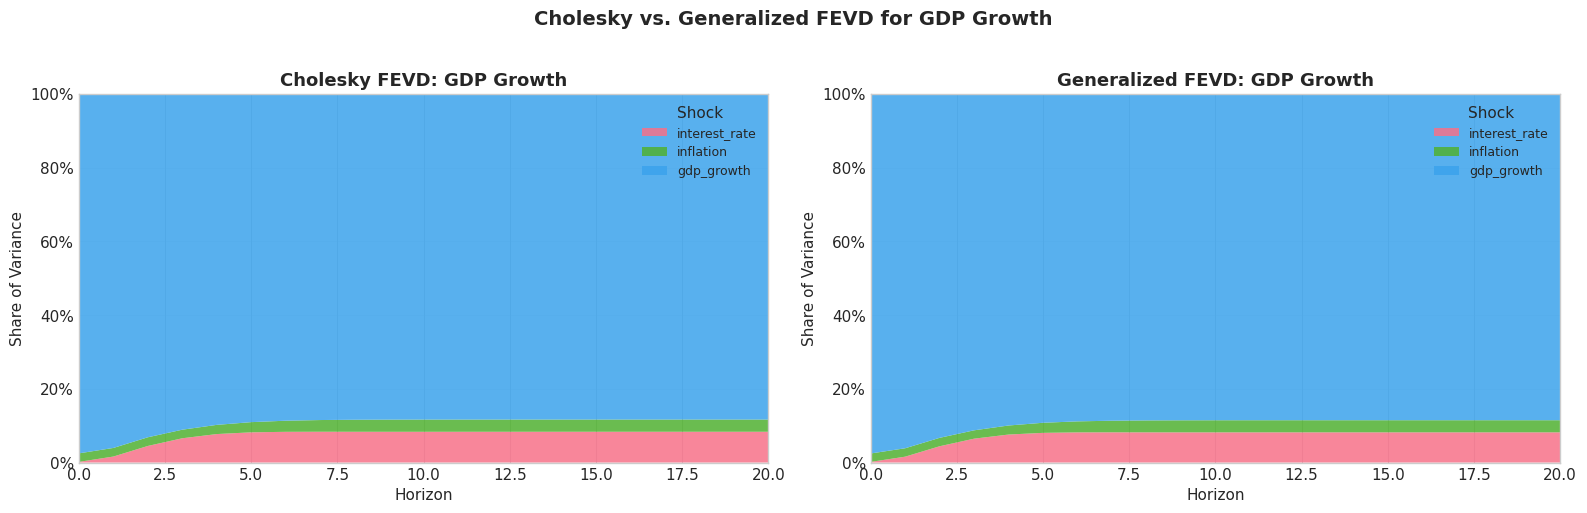

In [13]:
# Visualize the comparison side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

colors = sns.color_palette('husl', n_colors=fevd.K)
horizons = np.arange(fevd.periods + 1)

for ax, fevd_obj, title in zip(
    axes,
    [fevd, fevd_gen],
    ['Cholesky FEVD', 'Generalized FEVD']
):
    var_idx = fevd_obj.var_names.index('gdp_growth')
    decomp = fevd_obj.decomposition[:, var_idx, :]

    ax.stackplot(
        horizons,
        *[decomp[:, j] for j in range(fevd_obj.K)],
        labels=fevd_obj.var_names,
        colors=colors,
        alpha=0.85
    )

    ax.set_xlabel('Horizon', fontsize=11)
    ax.set_ylabel('Share of Variance', fontsize=11)
    ax.set_title(f'{title}: GDP Growth', fontsize=13, fontweight='bold')
    ax.set_xlim(0, fevd_obj.periods)
    ax.set_ylim(0, 1.0)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.legend(loc='upper right', fontsize=9, title='Shock')
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle(
    'Cholesky vs. Generalized FEVD for GDP Growth',
    fontsize=14, fontweight='bold', y=1.02
)
fig.tight_layout()
fig.savefig(FIGURE_DIR / '03_fevd_cholesky_vs_generalized.png', dpi=150, bbox_inches='tight')
plt.show()

### Key Differences

| Feature | Cholesky FEVD | Generalized FEVD |
|---------|--------------|------------------|
| Ordering | Required | Not required |
| Rows sum to 1 | Yes (exactly) | Yes (after normalization) |
| Identification | Recursive (Wold causal chain) | Uses observed covariance |
| When to use | When theory suggests clear ordering | When ordering is uncertain |

**Practical recommendation**: Always compute both. If results differ substantially, the FEVD is sensitive to identification assumptions and warrants further investigation.

---

## 5. Economic Applications

### Application 1: Policy Dominance

A central question in macroeconomics: **Is monetary policy the dominant driver of GDP variance?**

We can answer this by examining the FEVD share of interest rate shocks in the GDP growth decomposition.

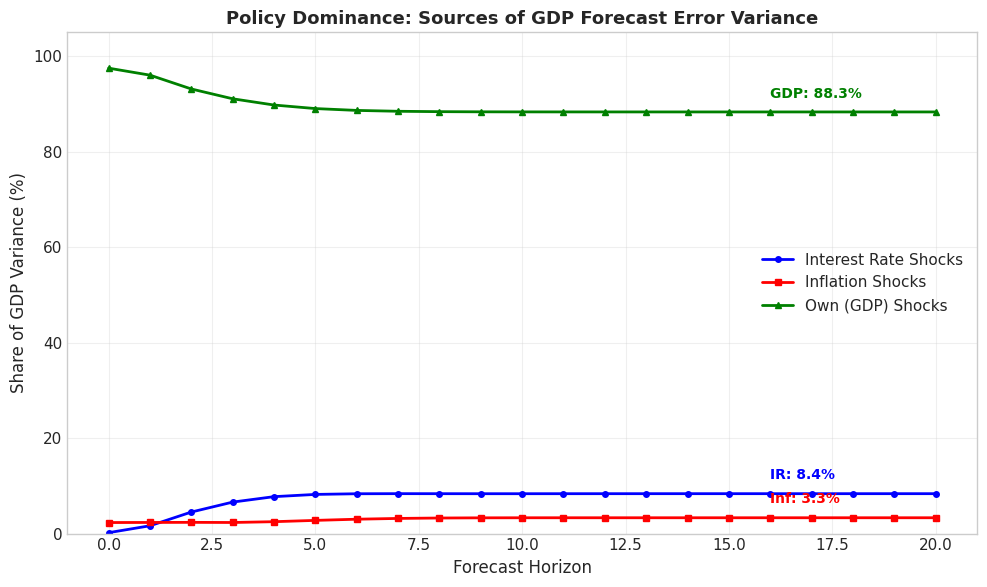


Policy Dominance Analysis:
At h=1:  Interest rate shocks explain 1.6% of GDP variance
At h=5:  Interest rate shocks explain 8.2% of GDP variance
At h=10: Interest rate shocks explain 8.4% of GDP variance
At h=20: Interest rate shocks explain 8.4% of GDP variance

Dominant shock at h=20: gdp_growth


In [14]:
# Application 1: Policy Dominance Analysis
# Extract the FEVD share of interest_rate shocks on gdp_growth
gdp_idx = fevd.var_names.index('gdp_growth')
ir_idx = fevd.var_names.index('interest_rate')
inf_idx = fevd.var_names.index('inflation')

horizons_plot = np.arange(fevd.periods + 1)

# FEVD shares for GDP growth from each shock
ir_share = fevd.decomposition[:, gdp_idx, ir_idx]
inf_share = fevd.decomposition[:, gdp_idx, inf_idx]
own_share = fevd.decomposition[:, gdp_idx, gdp_idx]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(horizons_plot, ir_share * 100, 'b-o', markersize=4, linewidth=2,
        label='Interest Rate Shocks')
ax.plot(horizons_plot, inf_share * 100, 'r-s', markersize=4, linewidth=2,
        label='Inflation Shocks')
ax.plot(horizons_plot, own_share * 100, 'g-^', markersize=4, linewidth=2,
        label='Own (GDP) Shocks')

ax.set_xlabel('Forecast Horizon', fontsize=12)
ax.set_ylabel('Share of GDP Variance (%)', fontsize=12)
ax.set_title('Policy Dominance: Sources of GDP Forecast Error Variance',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

# Annotate the long-run shares
for label, share, color in [
    ('IR', ir_share[-1], 'blue'),
    ('Inf', inf_share[-1], 'red'),
    ('GDP', own_share[-1], 'green')
]:
    ax.annotate(
        f'{label}: {share*100:.1f}%',
        xy=(fevd.periods, share * 100),
        xytext=(fevd.periods - 4, share * 100 + 3),
        fontsize=10, color=color, fontweight='bold'
    )

fig.tight_layout()
fig.savefig(FIGURE_DIR / '03_policy_dominance.png', dpi=150, bbox_inches='tight')
plt.show()

# Interpretation
print("\nPolicy Dominance Analysis:")
print("=" * 50)
print(f"At h=1:  Interest rate shocks explain {ir_share[1]*100:.1f}% of GDP variance")
print(f"At h=5:  Interest rate shocks explain {ir_share[5]*100:.1f}% of GDP variance")
print(f"At h=10: Interest rate shocks explain {ir_share[10]*100:.1f}% of GDP variance")
print(f"At h=20: Interest rate shocks explain {ir_share[20]*100:.1f}% of GDP variance")
print(f"\nDominant shock at h=20: {fevd.var_names[np.argmax(fevd.decomposition[20, gdp_idx, :])]}")

### Application 2: Financial Contagion

We now turn to the finance panel to study cross-market spillovers. The question: **Which shocks dominate equity return variance?**

This analysis is relevant for:
- Portfolio risk management
- Systemic risk assessment
- Understanding contagion channels

In [15]:
# Load finance panel data
df_finance = pd.read_csv('../data/finance_panel.csv')

print(f"Finance panel shape: {df_finance.shape}")
print(f"Countries: {df_finance['country'].nunique()}")
print(f"Time periods: {df_finance['time'].nunique()}")
print(f"Variables: {list(df_finance.columns)}")
print(f"\nSample:")
df_finance.head()

Finance panel shape: (5000, 6)
Countries: 50
Time periods: 100
Variables: ['country', 'time', 'stock_return', 'bond_return', 'fx_return', 'commodity_return']

Sample:


,country,time,stock_return,bond_return,fx_return,commodity_return
0,USA,1,-3.402790,-0.676121,0.624581,1.982125
1,USA,2,1.788977,5.948471,1.483817,3.461722
2,USA,3,3.625016,1.183435,-0.193397,2.638598
3,USA,4,-1.371861,0.066033,-1.013389,0.880011
4,USA,5,7.390902,-3.062495,1.995130,-3.497151


In [16]:
# Estimate VAR on financial returns
finance_vars = ['stock_return', 'bond_return', 'fx_return', 'commodity_return']

finance_data = PanelVARData(
    df_finance,
    endog_vars=finance_vars,
    entity_col='country',
    time_col='time',
    lags=2
)

finance_model = PanelVAR(finance_data)
finance_results = finance_model.fit(method='ols', cov_type='clustered')

print("Finance VAR(2) estimated successfully.")
print(f"Variables: {finance_vars}")

Finance VAR(2) estimated successfully.
Variables: ['stock_return', 'bond_return', 'fx_return', 'commodity_return']


In [17]:
# Compute Generalized FEVD for financial system (order-invariant)
fevd_finance = finance_results.fevd(
    periods=20,
    method='generalized'
)

# Display summary
print(fevd_finance.summary(horizons=[1, 5, 10, 20]))

Forecast Error Variance Decomposition (GENERALIZED)
Method: generalized

Variable: stock_return
--------------------------------------------------------------------------------
     Horizon  Shock stock_return  Shock bond_return  Shock fx_return  Shock commodity_return
--------------------------------------------------------------------------------
         h=1        94.12%         3.77%         1.95%         0.16%
         h=5        94.08%         3.80%         1.95%         0.17%
        h=10        94.08%         3.80%         1.95%         0.17%
        h=20        94.08%         3.80%         1.95%         0.17%

Variable: bond_return
--------------------------------------------------------------------------------
     Horizon  Shock stock_return  Shock bond_return  Shock fx_return  Shock commodity_return
--------------------------------------------------------------------------------
         h=1         4.85%        95.08%         0.03%         0.04%
         h=5         4.90%

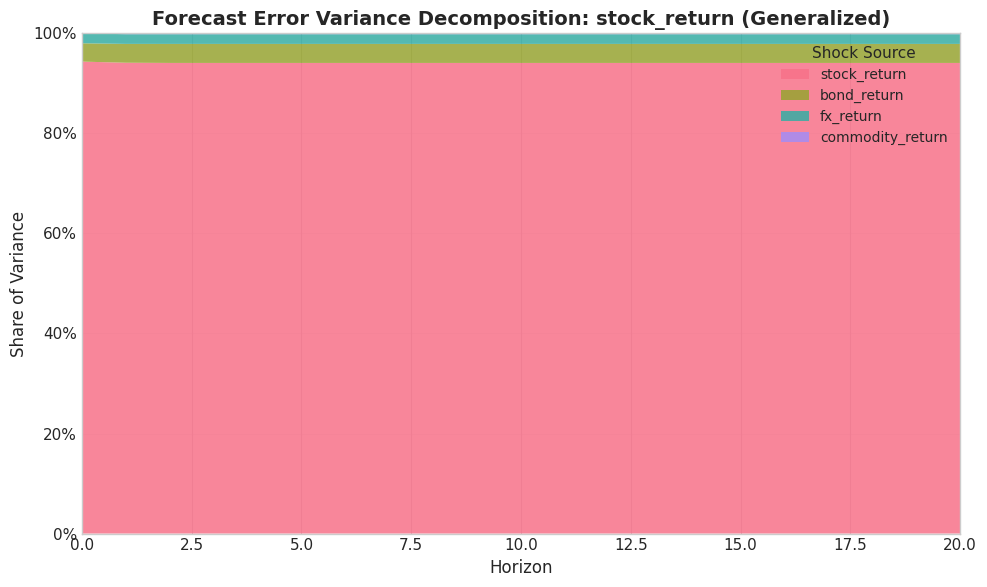


FEVD of Stock Returns at Key Horizons:
        stock_return bond_return fx_return commodity_return
horizon                                                    
1             94.12%       3.77%     1.95%            0.16%
5             94.08%       3.80%     1.95%            0.17%
10            94.08%       3.80%     1.95%            0.17%
20            94.08%       3.80%     1.95%            0.17%

Table saved to ../outputs/tables/03_fevd_stock_returns.csv


In [18]:
# Visualize FEVD for stock returns: Which shocks dominate equity variance?
fig = plot_fevd_stacked(
    fevd_finance,
    variable='stock_return',
    save_path=str(FIGURE_DIR / '03_fevd_stock_return.png')
)
plt.show()

# Extract stock return FEVD at key horizons
df_stock_fevd = fevd_finance.to_dataframe(variable='stock_return')
df_stock_key = df_stock_fevd[df_stock_fevd['horizon'].isin([1, 5, 10, 20])].copy()

print("\nFEVD of Stock Returns at Key Horizons:")
print("=" * 70)
display_df = df_stock_key.set_index('horizon').copy()
for col in finance_vars:
    display_df[col] = display_df[col].apply(lambda x: f"{x * 100:.2f}%")
print(display_df.to_string())

# Save
df_stock_key.to_csv(TABLE_DIR / '03_fevd_stock_returns.csv', index=False)
print(f"\nTable saved to {TABLE_DIR / '03_fevd_stock_returns.csv'}")

### Financial Contagion Interpretation

Key questions to consider from the finance FEVD:

1. **Self-determination**: What fraction of equity variance is due to own shocks vs. cross-market spillovers?
2. **Bond-equity nexus**: How important are bond market shocks for equity risk?
3. **Commodity channel**: Do commodity price shocks (e.g., oil) transmit to equity markets?
4. **FX exposure**: How much equity variance is attributable to exchange rate movements?

---

## 6. Bootstrap Confidence Intervals

FEVD point estimates can be uncertain, especially for small samples or nearly unstable systems. **Bootstrap confidence intervals** quantify this uncertainty by repeatedly resampling residuals, re-estimating the VAR, and recomputing FEVD.

The `panelbox.var.fevd.bootstrap_fevd()` function implements residual bootstrap:
1. Resample residuals with replacement
2. Re-generate data from the estimated VAR using the resampled residuals
3. Re-estimate the VAR coefficients on the bootstrap sample
4. Recompute FEVD from the new estimates
5. Repeat $B$ times to build the sampling distribution
6. Compute percentile-based confidence intervals

In [19]:
from panelbox.var.fevd import bootstrap_fevd

# Stack residuals across equations: shape (n_obs, K)
residuals = np.column_stack(results.resid_by_eq)
print(f"Residuals shape: {residuals.shape}")

# Run bootstrap FEVD (using 200 iterations for speed; use 500+ for publication)
ci_lower, ci_upper, boot_dist = bootstrap_fevd(
    A_matrices=results.A_matrices,
    Sigma=results.Sigma,
    residuals=residuals,
    periods=20,
    method='cholesky',
    n_bootstrap=200,
    ci_level=0.95,
    n_jobs=-1,
    seed=42,
    verbose=True
)

print(f"\nBootstrap distribution shape: {boot_dist.shape}")
print(f"CI lower shape: {ci_lower.shape}")
print(f"CI upper shape: {ci_upper.shape}")

Residuals shape: (1140, 3)
Running 200 bootstrap iterations for FEVD...


Bootstrap FEVD:   0%|          | 0/200 [00:00<?, ?it/s]

Bootstrap FEVD:  11%|█         | 22/200 [00:00<00:00, 197.60it/s]

Bootstrap FEVD:  22%|██▏       | 44/200 [00:02<00:09, 16.01it/s] 

Bootstrap FEVD:  33%|███▎      | 66/200 [00:02<00:05, 26.70it/s]

Bootstrap FEVD:  66%|██████▌   | 132/200 [00:02<00:00, 72.48it/s]

Bootstrap FEVD: 100%|██████████| 200/200 [00:02<00:00, 72.73it/s]


Bootstrap distribution shape: (200, 21, 3, 3)
CI lower shape: (21, 3, 3)
CI upper shape: (21, 3, 3)


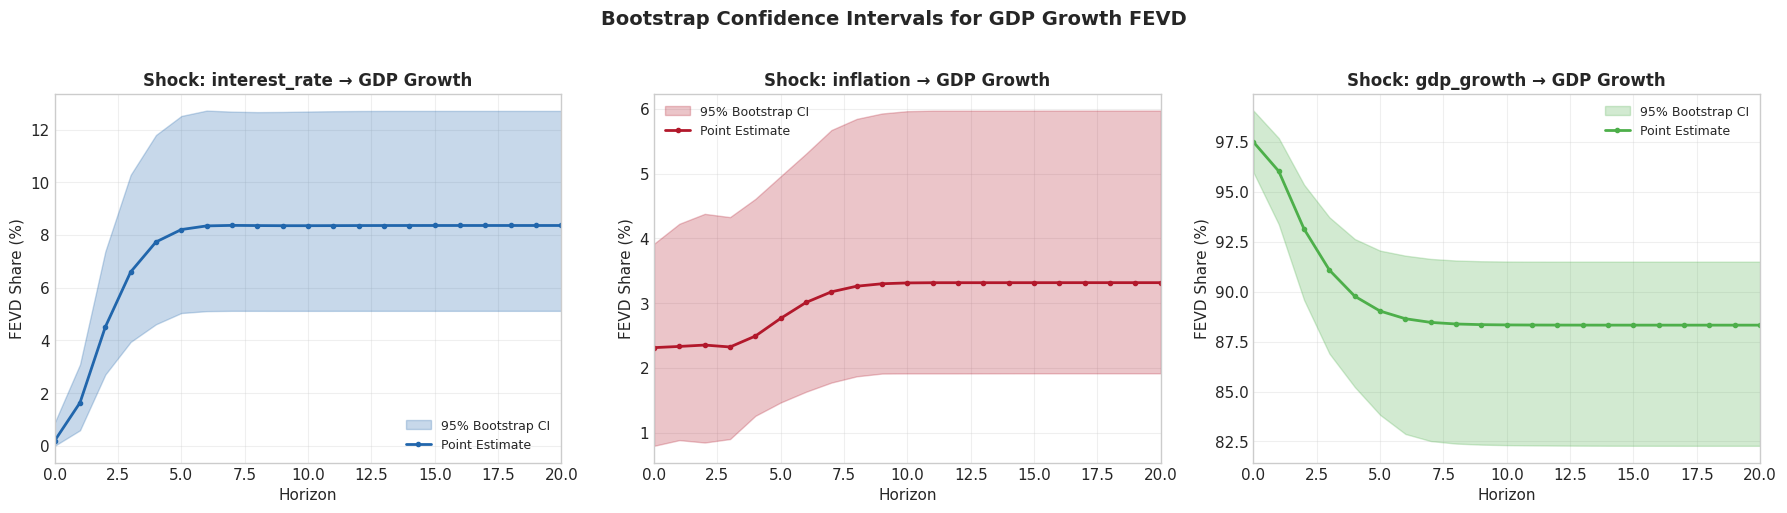


GDP Growth FEVD with 95% Bootstrap CI:
 Horizon | Shock            |    Point |    Lower |    Upper
---------------------------------------------------------------------------
       1 | interest_rate    |    1.64% |    0.59% |    3.09%
       1 | inflation        |    2.33% |    0.89% |    4.22%
       1 | gdp_growth       |   96.03% |   93.37% |   97.69%
       5 | interest_rate    |    8.20% |    5.04% |   12.51%
       5 | inflation        |    2.77% |    1.47% |    4.96%
       5 | gdp_growth       |   89.03% |   83.83% |   92.05%
      10 | interest_rate    |    8.35% |    5.12% |   12.68%
      10 | inflation        |    3.31% |    1.92% |    5.96%
      10 | gdp_growth       |   88.34% |   82.32% |   91.51%
      20 | interest_rate    |    8.36% |    5.12% |   12.71%
      20 | inflation        |    3.32% |    1.92% |    5.97%
      20 | gdp_growth       |   88.32% |   82.28% |   91.50%


In [20]:
# Visualize bootstrap CI for GDP growth FEVD
# Note: The FEVD ordering matches the Cholesky order used in results.fevd()
# Here the bootstrap uses the original variable order from A_matrices
# We use the same ordering: interest_rate=0, inflation=1, gdp_growth=2

gdp_boot_idx = 2  # gdp_growth is the 3rd variable in endog_vars order
horizons_boot = np.arange(21)
var_labels = ['interest_rate', 'inflation', 'gdp_growth']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ['#2166ac', '#b2182b', '#4daf4a']

for j in range(3):
    ax = axes[j]
    # Point estimate
    point = fevd.decomposition[:, gdp_boot_idx, j] * 100
    lower = ci_lower[:, gdp_boot_idx, j] * 100
    upper = ci_upper[:, gdp_boot_idx, j] * 100

    ax.fill_between(horizons_boot, lower, upper, alpha=0.25, color=colors[j],
                    label='95% Bootstrap CI')
    ax.plot(horizons_boot, point, color=colors[j], linewidth=2,
            marker='o', markersize=3, label='Point Estimate')

    ax.set_xlabel('Horizon', fontsize=11)
    ax.set_ylabel('FEVD Share (%)', fontsize=11)
    ax.set_title(f'Shock: {fevd.var_names[j]} → GDP Growth',
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 20)

fig.suptitle('Bootstrap Confidence Intervals for GDP Growth FEVD',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig(FIGURE_DIR / '03_fevd_bootstrap_ci.png', dpi=150, bbox_inches='tight')
plt.show()

# Print CI at key horizons
print("\nGDP Growth FEVD with 95% Bootstrap CI:")
print("=" * 75)
print(f"{'Horizon':>8} | {'Shock':<16} | {'Point':>8} | {'Lower':>8} | {'Upper':>8}")
print("-" * 75)
for h in [1, 5, 10, 20]:
    for j in range(3):
        pt = fevd.decomposition[h, gdp_boot_idx, j] * 100
        lo = ci_lower[h, gdp_boot_idx, j] * 100
        hi = ci_upper[h, gdp_boot_idx, j] * 100
        print(f"{h:>8} | {fevd.var_names[j]:<16} | {pt:>7.2f}% | {lo:>7.2f}% | {hi:>7.2f}%")

---

## 7. FEVD-IRF Consistency

A fundamental relationship links IRFs and FEVD: **variables with large IRF responses to a given shock should also show large FEVD shares from that shock**.

This is because FEVD is constructed from the squared cumulative IRF responses. Let's verify this consistency.

In [21]:
# Compute both IRF and FEVD for the same model
irf = results.irf(
    periods=20,
    method='cholesky',
    order=['interest_rate', 'inflation', 'gdp_growth'],
    verbose=False
)

# For each (impulse, response) pair, compute:
# 1. IRF peak magnitude (max absolute value across horizons)
# 2. FEVD share at h=10

irf_peaks = []
fevd_shares = []
pair_labels = []

K = fevd.K
h_eval = 10

for i in range(K):
    for j in range(K):
        # IRF peak: max |IRF| across all horizons for impulse j -> response i
        irf_line = irf.irf_matrix[:, i, j]
        peak = np.max(np.abs(irf_line))
        irf_peaks.append(peak)

        # FEVD share at h=h_eval
        share = fevd.decomposition[h_eval, i, j]
        fevd_shares.append(share)

        pair_labels.append(f"{fevd.var_names[j]} -> {fevd.var_names[i]}")

irf_peaks = np.array(irf_peaks)
fevd_shares = np.array(fevd_shares)

# Calculate correlation
correlation = np.corrcoef(irf_peaks, fevd_shares)[0, 1]

print(f"IRF-FEVD Consistency Analysis (h={h_eval})")
print("=" * 60)
print(f"{'Pair':<35} {'IRF Peak':>10} {'FEVD Share':>12}")
print("-" * 60)
for label, peak, share in zip(pair_labels, irf_peaks, fevd_shares):
    print(f"{label:<35} {peak:>10.4f} {share*100:>11.2f}%")
print(f"\nCorrelation: {correlation:.4f}")

IRF-FEVD Consistency Analysis (h=10)
Pair                                  IRF Peak   FEVD Share
------------------------------------------------------------
interest_rate -> interest_rate          1.0548       79.00%
inflation -> interest_rate              0.3222       16.51%
gdp_growth -> interest_rate             0.1649        4.49%
interest_rate -> inflation              0.0858        1.31%
inflation -> inflation                  1.3457       97.16%
gdp_growth -> inflation                 0.1291        1.53%
interest_rate -> gdp_growth             0.2293        8.35%
inflation -> gdp_growth                 0.1844        3.31%
gdp_growth -> gdp_growth                1.1975       88.34%

Correlation: 0.9988


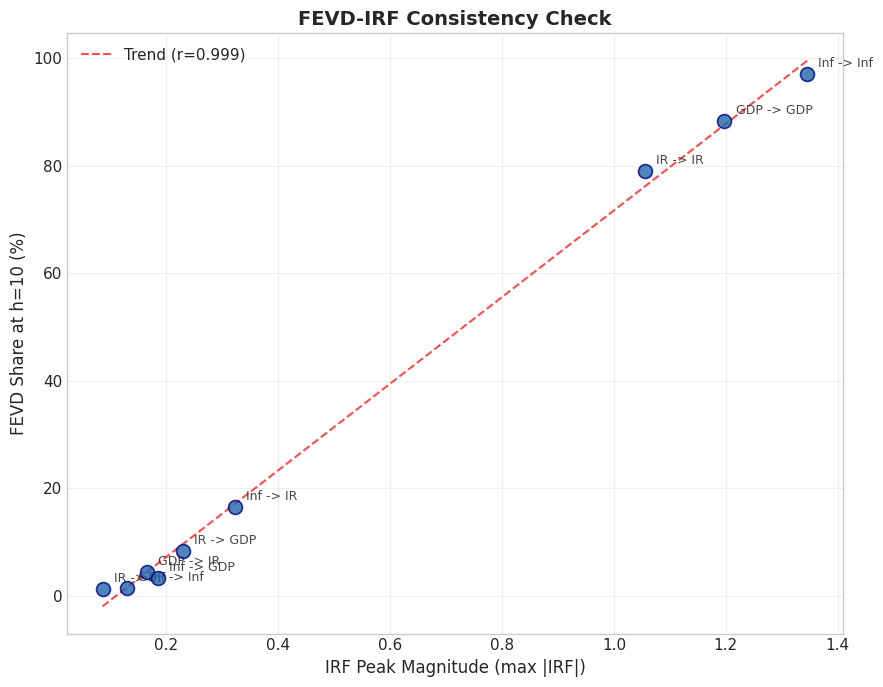


Correlation between IRF peak and FEVD share: 0.9988
Strong positive correlation -- FEVD and IRF are highly consistent.


In [22]:
# Scatter plot: IRF peak magnitude vs FEVD share
fig, ax = plt.subplots(figsize=(9, 7))

ax.scatter(irf_peaks, fevd_shares * 100, s=100, c='#2166ac', edgecolors='navy',
           linewidth=1.2, alpha=0.8, zorder=5)

# Label each point
for label, x, y in zip(pair_labels, irf_peaks, fevd_shares * 100):
    # Shorten labels
    short_label = label.replace('interest_rate', 'IR').replace(
        'inflation', 'Inf').replace('gdp_growth', 'GDP')
    ax.annotate(
        short_label, (x, y),
        textcoords='offset points', xytext=(8, 5),
        fontsize=9, alpha=0.85
    )

# Add trend line
z = np.polyfit(irf_peaks, fevd_shares * 100, 1)
p = np.poly1d(z)
x_line = np.linspace(irf_peaks.min(), irf_peaks.max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=1.5, alpha=0.7, label=f'Trend (r={correlation:.3f})')

ax.set_xlabel('IRF Peak Magnitude (max |IRF|)', fontsize=12)
ax.set_ylabel(f'FEVD Share at h={h_eval} (%)', fontsize=12)
ax.set_title('FEVD-IRF Consistency Check', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig(FIGURE_DIR / '03_fevd_irf_consistency.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nCorrelation between IRF peak and FEVD share: {correlation:.4f}")
if correlation > 0.7:
    print("Strong positive correlation -- FEVD and IRF are highly consistent.")
elif correlation > 0.4:
    print("Moderate correlation -- general consistency, some pairs diverge.")
else:
    print("Weak correlation -- investigate possible identification issues.")

### Why Consistency Matters

The positive correlation between IRF peak magnitudes and FEVD shares confirms that:
1. The FEVD correctly reflects the dynamic importance of each shock
2. Shocks that produce large IRF responses also explain substantial forecast variance
3. The Cholesky identification scheme is internally consistent

If you observe weak or negative correlation, it may indicate:
- The IRF and FEVD are computed with different orderings
- Numerical issues in the estimation
- The peak magnitude is misleading (e.g., large but transient responses that contribute little cumulative variance)

---

## Summary

### Key Takeaways

1. **FEVD quantifies relative importance**: It decomposes the forecast error variance of each variable into contributions from all structural shocks, answering "how much does shock $j$ matter for variable $i$?"

2. **Cholesky vs. Generalized**: Cholesky FEVD requires a recursive ordering and is suitable when theory provides a clear causal structure. Generalized FEVD is order-invariant and more robust when ordering is uncertain.

3. **Stacked area charts** are the standard visualization, showing how variance shares evolve over the forecast horizon.

4. **Economic applications**: FEVD answers policy questions ("Is monetary policy the dominant driver of GDP?") and financial risk questions ("What drives equity variance?").

5. **Bootstrap confidence intervals** quantify uncertainty in FEVD estimates, showing whether differences in shares are statistically meaningful.

6. **FEVD-IRF consistency**: Large IRF responses should correspond to large FEVD shares, providing a useful internal validation.

### API Quick Reference

```python
# Compute FEVD
fevd = results.fevd(periods=20, method='cholesky', order=[...])
fevd = results.fevd(periods=20, method='generalized')

# Access decomposition
fevd.decomposition[h, i, j]  # share of var i from shock j at horizon h
fevd.summary(horizons=[1, 5, 10, 20])
fevd.to_dataframe(variable='gdp_growth')

# Bootstrap confidence intervals
from panelbox.var.fevd import bootstrap_fevd
ci_lower, ci_upper, boot_dist = bootstrap_fevd(
    results.A_matrices, results.Sigma, residuals,
    periods=20, method='cholesky', n_bootstrap=500
)

# Visualize
fevd.plot(variables=['gdp_growth'], backend='matplotlib', show=False)
```

### Next Steps

- **Notebook 04**: Granger Causality Testing -- statistical tests for predictive relationships
- **Notebook 05**: VECM and Cointegration -- when variables share long-run trends

---

## 8. Exercises

### Exercise 1: Ordering Sensitivity in FEVD (Easy)

Compute Cholesky FEVD with **two different orderings**:
1. `['interest_rate', 'inflation', 'gdp_growth']` (monetary policy first)
2. `['gdp_growth', 'inflation', 'interest_rate']` (output first)

Compare the decomposition of GDP growth variance at horizons $h = 1, 5, 10, 20$. How sensitive are the results to the ordering? Discuss why Generalized FEVD might be preferred.

**Expected output**: A table showing FEVD shares for GDP growth under both orderings at $h = 1, 5, 10, 20$.

In [23]:
# Exercise 1: Ordering Sensitivity
# YOUR CODE HERE

# Hint:
# fevd_order1 = results.fevd(periods=20, method='cholesky',
#                            order=['interest_rate', 'inflation', 'gdp_growth'])
# fevd_order2 = results.fevd(periods=20, method='cholesky',
#                            order=['gdp_growth', 'inflation', 'interest_rate'])
# Compare fevd_order1.decomposition vs fevd_order2.decomposition for gdp_growth

### Exercise 2: Identifying Dominant Shocks (Medium)

For each variable in the macro system at horizon $h=10$:
1. Identify which shock explains the **largest share** of forecast error variance
2. Construct a "dominance table" showing the dominant shock and its percentage for each variable
3. Create a **stacked bar chart** at $h=10$ for all variables side by side

**Expected output**: A $K \times 1$ table with the dominant shock for each variable, plus a stacked bar chart.

In [24]:
# Exercise 2: Identifying Dominant Shocks
# YOUR CODE HERE

# Hint:
# h = 10
# for i, var in enumerate(fevd.var_names):
#     shares = fevd.decomposition[h, i, :]
#     dominant_j = np.argmax(shares)
#     print(f"{var}: dominant shock = {fevd.var_names[dominant_j]} ({shares[dominant_j]*100:.1f}%)")

### Exercise 3: FEVD-IRF Consistency Check (Medium)

Extend the FEVD-IRF consistency analysis from Section 6:
1. Compute the **cumulative absolute IRF** (sum of |IRF| over horizons 0 to 10) instead of the peak
2. Compare this with the FEVD share at $h=10$
3. Create a scatter plot and compute the correlation
4. Which measure (peak vs. cumulative) correlates more strongly with FEVD shares? Why?

**Expected output**: Scatter plot and correlation coefficient for cumulative-IRF vs. FEVD.

In [25]:
# Exercise 3: FEVD-IRF Consistency
# YOUR CODE HERE

# Hint:
# cumulative_irf = []
# for i in range(K):
#     for j in range(K):
#         cum = np.sum(np.abs(irf.irf_matrix[:h_eval+1, i, j]))
#         cumulative_irf.append(cum)

### Exercise 4: Finance Panel FEVD (Hard)

Using the `finance_panel.csv` data:
1. Estimate a VAR(2) with all four asset return variables
2. Compute **both** Cholesky and Generalized FEVD with `periods=20`
3. For **stock returns**, create a table showing FEVD shares at $h = 1, 5, 10, 20$
4. Create stacked area plots for all four variables
5. Discuss: Which shocks are most important for equity risk? How does this change over the forecast horizon?

**Expected output**: FEVD table for stock returns, stacked area plots for all variables, risk factor attribution discussion.

*Hint*: The finance panel uses `entity_col='country'` and `time_col='time'` (not `'quarter'`).

In [26]:
# Exercise 4: Finance Panel FEVD
# YOUR CODE HERE

# Hint:
# df_fin = pd.read_csv('../data/finance_panel.csv')
# fin_data = PanelVARData(df_fin,
#     endog_vars=['stock_return', 'bond_return', 'fx_return', 'commodity_return'],
#     entity_col='country', time_col='time', lags=2)
# fin_model = PanelVAR(fin_data)
# fin_results = fin_model.fit(method='ols', cov_type='clustered')
# fevd_fin = fin_results.fevd(periods=20, method='generalized')

---

**References:**
- Lutkepohl, H. (2005). *New Introduction to Multiple Time Series Analysis*. Springer-Verlag.
- Pesaran, H. H., & Shin, Y. (1998). Generalized impulse response analysis in linear multivariate models. *Economics Letters*, 58(1), 17-29.
- Sims, C. A. (1980). Macroeconomics and reality. *Econometrica*, 48(1), 1-48.